## **Food-101:**

[Food 101 dataset](https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz) was originally used in paper [Food-101 Mining Discriminative Components with Random Forest](https://link.springer.com/chapter/10.1007/978-3-319-10599-4_29). This dataset consist of 101 types of food, meaning there are 101 classes. For each class, there are 750 training images and 250 test images. The images have a maximum side length of 512 pixels. 

The goal of this project is to obtain > 85% top-1 test accuracy by using ResNet50 or smaller network and Food 101 dataset. 

### Explonatory Analysis 

Although we cannot visualize all images, but if we look deeper into the dataset manually, we can find that there are some challenges with images in this dataset : 

1.   The dataset contains few noises where the images are wrongly labeled. For example, a beer is in chiken wings class.
2.   In a single image, there could be two type of foods, although the image has only single lable. For example, french fries appears in some classes such as sandwidh, fish & chips, and ribs.
3.   The images were taken in different condition (lightning, distance between camera, etc.). Thus it implies variability between images in each class.
4.   Similarity between different category of food.

<!--- To grasp the pattern of the data, we visualize few images that describe the challenges below. -->

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

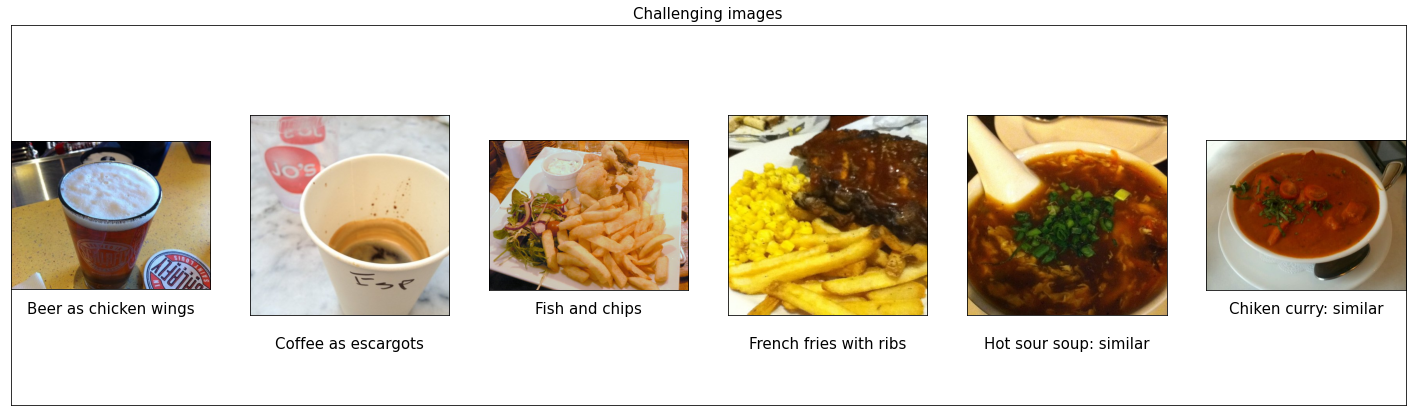

In [261]:
fig = plt.figure(figsize=(25, 7))
plt.title("Challenging images", fontsize=15, loc='center')
plt.yticks([])
plt.xticks([])

images_path = ["dataset/train/chicken_wings/297786.jpg", 
               "dataset/train/escargots/1036454.jpg",
               "dataset/train/fish_and_chips/302932.jpg", 
               "dataset/train/baby_back_ribs/510053.jpg", 
               "dataset/train/hot_and_sour_soup/1010638.jpg", 
               "dataset/train/chicken_curry/994930.jpg"]

images_name = ["Beer as chicken wings", 
               "Coffee as escargots", 
               "Fish and chips", 
               "French fries with ribs", 
               "Hot sour soup: similar", 
               "Chiken curry: similar"]

for i in np.arange(6):
    ax = fig.add_subplot(1, 12/2, i+1, xticks=[], yticks=[])
    img = mpimg.imread(images_path[i])
    plt.imshow(img)
    ax.set_title(images_name[i], fontsize=15, y=-0.2)


### Model Training

To overcome these challenges, we employ several strategies in training the neural network model. 

If we train the network from scratch with a relatively small dataset, it could lead to overfitting. Thus, we use pretrained Resnet-50.

Afterwards, the last layer or the classifier layer is replaced with a new feedforward network so the total output of the model has the same number of  Food 101 class (in pretrained Resnet-50 there are 1000 output or classes).

At first step, we only train the last layer and freeze the remaining layer, because the last layer is untrained and naive. We want to train the last layer until it perform decently before fine-tuning the entire model.  

Then we gradually unfreezing the layers from the later one until the first layer. We unfreeze the fourth layer of Resnet-50, then train it along with the linear layer. Then we unfreeze the third layer and train it along with fourth layer and the linear layer. And so on, until we reaches the base layer. 

We also apply discriminative learning rates. It means that we train the earlier layer with smaller learning rate and train the deeper layer layer with comparatively larger learning rate. The reason is that the earlier layers do fundamental feature extraction, i.e. identifying curves and edges. So these layers do not need to be aggresively trained. The later layers was trained to extract information specific to Imagenet dataset. While we train in a new dataset, so they are retrained more aggresively.

We use [AdamW](https://arxiv.org/abs/1711.05101) as our optimizer as the author proved that the models trained with AdamW generalize much better than models trained with regular Adam.

During each steps, we use [learning rate finder](https://github.com/davidtvs/pytorch-lr-finder). We choose the learning rate where the loss is at its lowest or where the convergence loss is steep. We also apply different learning rate for each different layer with a ratio of 10 or using logarithmic interpolation.

Lastly, we evaluate the test images using TTA (Test Time Augmentation). For each test image, we will predict on several augmented version of that images then average their prediction scores. TTA was performed in order to give a trained model every chance of making a robust prediction. We use horizontal flip and cropping for TTA, as suggested by this [paper](https://arxiv.org/abs/1409.1556). 


In [339]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

from torch import nn
import torch.nn.functional as F
from torch import optim

import numpy as np
import pandas as pd

import time
import datetime

import scipy as sp
import scipy.interpolate

from matplotlib.lines import Line2D
from sklearn import manifold

In [5]:
try:
    from torch_lr_finder import LRFinder
except ImportError:
    # Run from source
    import sys
    sys.path.insert(0, '..')
    from torch_lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [6]:
def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

In [7]:
def tester(model, criterion, device, testloader):
    test_loss = 0.0
    total = 0
    correct = 0

    # turn off gradient for testing, saves memory and computation 
    with torch.no_grad():
        # prep model for evaluation
        model.eval() 

        for inputs, labels in testloader:
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            # forward pass the input into the model
            logps = model(inputs)
            # calculate loss
            loss = criterion(logps, labels)
            # update running test loss 
            test_loss += loss.item()
            # convert output probabilities to predicted class
            _, pred = torch.max(logps, 1)
            # compare predictions to true label
            compare = np.squeeze(pred.eq(labels.data.view_as(pred)))

            correct += compare.sum().item()
            total += labels.size(0)
    
    # calculate average loss over an epoch
    test_loss = test_loss/len(testloader)

    # calculate overall test accuracy
    accuracy = 100 * correct / total
    
    return (test_loss, accuracy)

In [8]:
def trainer(epochs, model, optimizer, criterion, device, trainloader, testloader):
    
    for epoch in range(epochs):
  
        train_loss = 0.0
        start = time.time()

        # prep model for training
        model.train()
        for inputs, labels in trainloader: 

            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            # update running training loss
            train_loss += loss.item()

        # training time
        end = time.time()
        total_train_time = end - start

        # calculate average loss over an epoch
        train_loss = train_loss/len(trainloader)
        
        # call test network model
        test_loss, accuracy = tester(model, criterion, device, testloader)
    
        print(f"Epoch {epoch+1}.. " f"Training Time: {datetime.timedelta(seconds=int(total_train_time))}.. " 
              f"Avg Train Loss {train_loss:.3f}.. " f"Avg Test Loss {test_loss:.3f}.. "
              f"Top-1 Test Accuracy {accuracy:.3f}.. \n")

In [9]:
# identifying total class of food 101 dataset
data_dir = "food-101"

classes_text = open(data_dir + "/meta/classes.txt", "r")
num_class = 0
for label in classes_text:
    num_class +=1
num_class

101

In [10]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# load pretrained Resnet 50
model = models.resnet50(pretrained=True).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False

In [13]:
# replace the last layer with a new linear layer
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(1024, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, num_class)).to(device)

In [14]:
# set the loss function
criterion = nn.CrossEntropyLoss()

In [15]:
# set the optimizer AdamW 
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-7)

In [16]:
# set train augmentation function
train_transform_list = [transforms.RandomRotation(30),
                       transforms.RandomResizedCrop(224),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                        ]
train_transforms = transforms.Compose(train_transform_list)

# set test augmentation function
test_transforms = transforms.Compose([transforms.Resize(255, interpolation=3),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# Load the dataset (train and test)
dataset_dir = "dataset"
train_data = datasets.ImageFolder(dataset_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(dataset_dir + '/test', transform=test_transforms)

# Create an iterable over the dataset.
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=0)

**_First round_**

We start fine-tuning the model by first training only the last layer (the linear layer).

Before that, we use the learning rate finder to choose the learning rate

In [30]:
# find lr for AdamW
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


In [31]:
# plot the loss-learning rate graph
lr_finder.plot()

# reset the model and optimizer to their initial state 
lr_finder.reset()

In [82]:
# set new learning rate based on the loss-learning rate graph
optimizer = optim.AdamW(model.fc.parameters(), lr=0.001)

In [83]:
# train only last layer
trainer(4, model, optimizer, criterion, device, trainloader, testloader)

Epoch 1.. Training Time: 0:34:39.. Avg Train Loss 3.278.. Avg Test Loss 2.113.. Top-1 Test Accuracy 45.331.. 

Epoch 2.. Training Time: 0:34:49.. Avg Train Loss 2.745.. Avg Test Loss 1.948.. Top-1 Test Accuracy 49.469.. 

Epoch 3.. Training Time: 0:34:41.. Avg Train Loss 2.622.. Avg Test Loss 1.851.. Top-1 Test Accuracy 52.028.. 

Epoch 4.. Training Time: 0:34:25.. Avg Train Loss 2.570.. Avg Test Loss 1.802.. Top-1 Test Accuracy 52.725.. 



In [84]:
# save the model
torch.save(model.state_dict(), 'model_food101_resnet50_4.pt')

**_Second round_**

Now we unfreeze the 4<sup>th</sup> layer. And we fine-tune the last layer and the 4<sup>th</sup> layer.

We use the learning rate finder to choose the learning rate again since now the trainable layer are different as before.  

In [90]:
# Unfreeze the parameters of layer 4
for param in model.layer4.parameters():
    param.requires_grad = True

In [97]:
# set the optimizer for the learning rate finder
optimizer = optim.AdamW(model.parameters(), lr=1e-7)

# find lr for AdamW
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


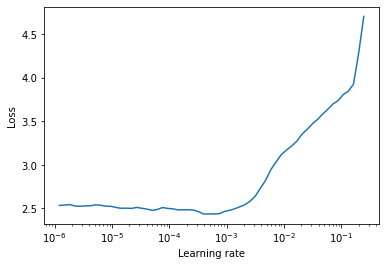

In [98]:
# plot the loss-learning rate graph
lr_finder.plot()
# reset the model and optimizer to their initial state 
lr_finder.reset()

We set the learning rate for the 4<sup>th</sup> layer lower than the linear layer by the ratio of 10.

In [100]:
# set new learning rate based on the loss-learning rate graph
new_lr = 1e-4
optimizer = optim.AdamW([{'params': model.fc.parameters(), 'lr':new_lr},
                         {'params': model.layer4.parameters(), 'lr':0.1*new_lr}])

In [107]:
# train the linear classifier layer and layer 4
trainer(4, model, optimizer, criterion, device, trainloader, testloader)

Epoch 1.. Training Time: 0:40:53.. Avg Train Loss 2.268.. Avg Test Loss 1.429.. Top-1 Test Accuracy 61.826.. 

Epoch 2.. Training Time: 0:37:37.. Avg Train Loss 2.093.. Avg Test Loss 1.312.. Top-1 Test Accuracy 64.760.. 

Epoch 3.. Training Time: 0:37:48.. Avg Train Loss 1.971.. Avg Test Loss 1.230.. Top-1 Test Accuracy 66.547.. 

Epoch 4.. Training Time: 0:36:29.. Avg Train Loss 1.894.. Avg Test Loss 1.136.. Top-1 Test Accuracy 69.101.. 



In [108]:
# save the model
torch.save(model.state_dict(), 'model_food101_resnet50_8.pt')

**_Third round_**

Now we unfreeze the 3<sup>th</sup> layer. And we fine-tune the last layer, the 4<sup>th</sup> layer and the 3<sup>th</sup> layer.

We use the learning rate finder to choose the learning rate again since now the trainable layer are different as before.  

In [112]:
# Unfreeze the parameters of layer 3
for param in model.layer3.parameters():
    param.requires_grad = True

In [113]:
# set the optimizer for the learning rate finder
optimizer = optim.AdamW(model.parameters(), lr=1e-7)

# find lr for AdamW
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


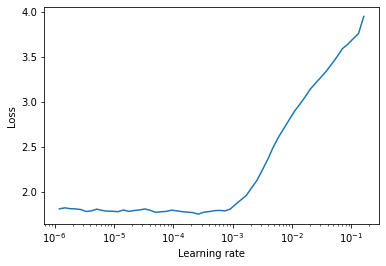

In [114]:
# plot the loss-learning rate graph
lr_finder.plot()
# reset the model and optimizer to their initial state 
lr_finder.reset()

We set the learning rate for earliear layers lower than the last layer by the ratio of 10.

In [115]:
# set new learning rate based on the loss-learning rate graph
new_lr = 1e-4
optimizer = optim.AdamW([{'params': model.fc.parameters(), 'lr':new_lr},
                         {'params': model.layer4.parameters(), 'lr':0.1*new_lr},
                         {'params': model.layer3.parameters(), 'lr':0.01*new_lr}])

In [119]:
# train the linear classifier layer, layer 4 and layer 3
trainer(4, model, optimizer, criterion, device, trainloader, testloader)

Epoch 1.. Training Time: 0:41:26.. Avg Train Loss 1.807.. Avg Test Loss 1.077.. Top-1 Test Accuracy 70.642.. 

Epoch 2.. Training Time: 0:39:56.. Avg Train Loss 1.732.. Avg Test Loss 1.031.. Top-1 Test Accuracy 71.477.. 

Epoch 3.. Training Time: 0:39:59.. Avg Train Loss 1.673.. Avg Test Loss 0.986.. Top-1 Test Accuracy 72.705.. 

Epoch 4.. Training Time: 0:39:46.. Avg Train Loss 1.625.. Avg Test Loss 0.965.. Top-1 Test Accuracy 73.192.. 



In [120]:
# save the model
torch.save(model.state_dict(), 'model_food101_resnet50_12.pt')

**_Fourth round_**

Now we unfreeze the 2<sup>nd</sup> layer. And we fine-tune the last layer, the 4<sup>th</sup> layer, the 3<sup>th</sup> layer and the 2<sup>nd</sup> layer.

We use the learning rate finder to choose the learning rate again since now the trainable layer are different as before.  

In [123]:
# Unfreeze the parameters of layer 2
for param in model.layer2.parameters():
    param.requires_grad = True

In [124]:
# set the optimizer for the learning rate finder
optimizer = optim.AdamW(model.parameters(), lr=1e-8)

# find lr for AdamW
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


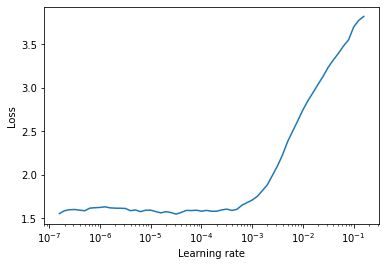

In [125]:
# plot the loss-learning rate graph
lr_finder.plot()
# reset the model and optimizer to their initial state 
lr_finder.reset()

We set the learning rate for earliear layers lower than the last layer. Now the learning rates are decided by logarithmic interpolation because if we use the 10 ratio then the learning rate in early layers will be too low.

In [227]:
# set new learning rate based on the loss-learning rate graph
new_lr = log_interp1d([1,4], [1e-4,1e-6])
optimizer = optim.AdamW([{'params': model.fc.parameters(), 'lr':new_lr(1)},
                         {'params': model.layer4.parameters(), 'lr':new_lr(2)},
                         {'params': model.layer3.parameters(), 'lr':new_lr(3)},
                         {'params': model.layer2.parameters(), 'lr':new_lr(4)}])

In [228]:
# train the linear classifier layer, layer 4, layer 3 and layer 2
trainer(4, model, optimizer, criterion, device, trainloader, testloader)

Epoch 1.. Training Time: 0:43:27.. Avg Train Loss 1.570.. Avg Test Loss 0.904.. Top-1 Test Accuracy 74.919.. 

Epoch 2.. Training Time: 0:41:40.. Avg Train Loss 1.514.. Avg Test Loss 0.883.. Top-1 Test Accuracy 75.628.. 

Epoch 3.. Training Time: 0:41:51.. Avg Train Loss 1.470.. Avg Test Loss 0.848.. Top-1 Test Accuracy 76.448.. 

Epoch 4.. Training Time: 0:42:31.. Avg Train Loss 1.437.. Avg Test Loss 0.840.. Top-1 Test Accuracy 76.586.. 



In [229]:
# save the model
torch.save(model.state_dict(), 'model_food101_resnet50_16.pt')

**_Fifth round_**

Now we unfreeze all layers. Then we fine-tune the whole model.

We use the learning rate finder to choose the learning rate again since now the trainable layer are different as before.  

In [17]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

In [18]:
# set the optimizer for the learning rate finder
optimizer = optim.AdamW(model.parameters(), lr=1e-9)

# find lr for AdamW
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


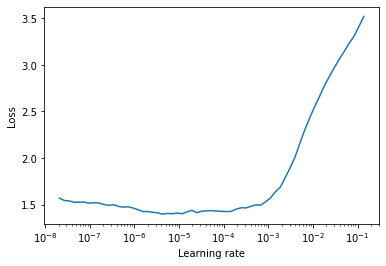

In [19]:
# plot the loss-learning rate graph
lr_finder.plot()
# reset the model and optimizer to their initial state 
lr_finder.reset()

We set the learning rate for earliear layers lower than the last layer. 
The learning rates are decided by logarithmic interpolation again because if we use the 10 ratio then the learning rate in early layers will be too low.

In [20]:
# set new learning rate based on the loss-learning rate graph
new_lr = log_interp1d([1,5], [2*1e-4,1e-5])
optimizer = optim.AdamW([{'params': model.fc.parameters(), 'lr':new_lr(1)},
                         {'params': model.layer4.parameters(), 'lr':new_lr(2)},
                         {'params': model.layer3.parameters(), 'lr':new_lr(3)},
                         {'params': model.layer2.parameters(), 'lr':new_lr(4)},
                         {'params': model.layer1.parameters(), 'lr':new_lr(5)},
                         {'params': model.conv1.parameters()}, {'params': model.bn1.parameters()}], lr=1e-5)

In [21]:
# train all layers
trainer(4, model, optimizer, criterion, device, trainloader, testloader)

Epoch 1.. Training Time: 0:47:45.. Avg Train Loss 1.546.. Avg Test Loss 0.872.. Top-1 Test Accuracy 76.293.. 

Epoch 2.. Training Time: 0:45:09.. Avg Train Loss 1.447.. Avg Test Loss 0.817.. Top-1 Test Accuracy 77.315.. 

Epoch 3.. Training Time: 0:45:51.. Avg Train Loss 1.358.. Avg Test Loss 0.793.. Top-1 Test Accuracy 78.352.. 

Epoch 4.. Training Time: 0:44:18.. Avg Train Loss 1.294.. Avg Test Loss 0.747.. Top-1 Test Accuracy 79.263.. 



In [22]:
# save the model
torch.save(model.state_dict(), 'model_food101_resnet50_20.pt')

**_Last round_**

We unfreeze all layers and fine-tune the whole model.

We train the model for 12 epochs. And we repeat the same steps for every 4 epochs (finding learning rate, then training).

In [23]:
# set the optimizer for the learning rate finder
optimizer = optim.AdamW(model.parameters(), lr=1e-9)

# find lr for AdamW
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


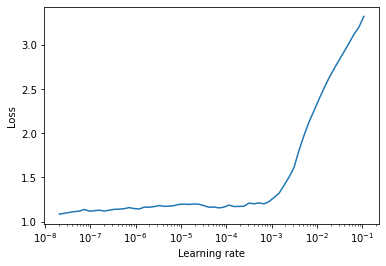

In [24]:
# plot the loss-learning rate graph
lr_finder.plot()
# reset the model and optimizer to their initial state 
lr_finder.reset()

In [25]:
# set new learning rate based on the loss-learning rate graph
new_lr = log_interp1d([1,5], [2*1e-6,1e-8])
optimizer = optim.AdamW([{'params': model.fc.parameters(), 'lr':new_lr(1)},
                         {'params': model.layer4.parameters(), 'lr':new_lr(2)},
                         {'params': model.layer3.parameters(), 'lr':new_lr(3)},
                         {'params': model.layer2.parameters(), 'lr':new_lr(4)},
                         {'params': model.layer1.parameters(), 'lr':new_lr(5)},
                         {'params': model.conv1.parameters()}, {'params': model.bn1.parameters()}], lr=1e-8)

In [28]:
# train all layers
trainer(4, model, optimizer, criterion, device, trainloader, testloader)

Epoch 1.. Training Time: 0:47:48.. Avg Train Loss 1.195.. Avg Test Loss 0.709.. Top-1 Test Accuracy 80.384.. 

Epoch 2.. Training Time: 0:46:11.. Avg Train Loss 1.170.. Avg Test Loss 0.700.. Top-1 Test Accuracy 80.721.. 

Epoch 3.. Training Time: 0:44:54.. Avg Train Loss 1.163.. Avg Test Loss 0.698.. Top-1 Test Accuracy 80.737.. 

Epoch 4.. Training Time: 0:45:14.. Avg Train Loss 1.152.. Avg Test Loss 0.676.. Top-1 Test Accuracy 81.275.. 



In [29]:
# save the model
torch.save(model.state_dict(), 'model_food101_resnet50_24.pt')

In [15]:
# unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True

In [89]:
# set the optimizer for the learning rate finder
optimizer = optim.AdamW(model.parameters(), lr=1e-9)

# find lr for AdamW
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


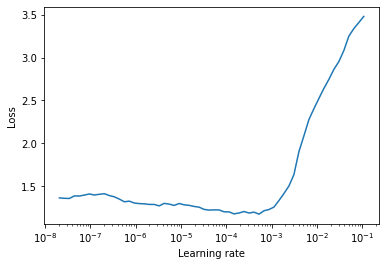

In [90]:
# plot the loss-learning rate graph
lr_finder.plot()
# reset the model and optimizer to their initial state 
lr_finder.reset()

In [16]:
# set new learning rate based on the loss-learning rate graph
new_lr = log_interp1d([1,5], [4*1e-4,1e-6])
optimizer = optim.AdamW([{'params': model.fc.parameters(), 'lr':new_lr(1)},
                         {'params': model.layer4.parameters(), 'lr':new_lr(2)},
                         {'params': model.layer3.parameters(), 'lr':new_lr(3)},
                         {'params': model.layer2.parameters(), 'lr':new_lr(4)},
                         {'params': model.layer1.parameters(), 'lr':new_lr(5)},
                         {'params': model.conv1.parameters()}, {'params': model.bn1.parameters()}], lr=1e-6)

In [17]:
# train all layers
trainer(4, model, optimizer, criterion, device, trainloader, testloader)

Epoch 1.. Training Time: 0:51:43.. Avg Train Loss 1.193.. Avg Test Loss 0.679.. Top-1 Test Accuracy 81.022.. 

Epoch 2.. Training Time: 0:45:33.. Avg Train Loss 1.128.. Avg Test Loss 0.675.. Top-1 Test Accuracy 81.299.. 

Epoch 3.. Training Time: 0:45:47.. Avg Train Loss 1.097.. Avg Test Loss 0.655.. Top-1 Test Accuracy 82.063.. 

Epoch 4.. Training Time: 0:45:16.. Avg Train Loss 1.076.. Avg Test Loss 0.648.. Top-1 Test Accuracy 82.372.. 



In [18]:
# save the model
torch.save(model.state_dict(), 'model_food101_resnet50_28.pt')

In [19]:
# unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True

In [20]:
# set the optimizer for the learning rate finder
optimizer = optim.AdamW(model.parameters(), lr=1e-9)

# find lr for AdamW
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


In [21]:
# plot the loss-learning rate graph
lr_finder.plot()
# reset the model and optimizer to their initial state 
lr_finder.reset()

In [22]:
# set new learning rate based on the loss-learning rate graph
new_lr = log_interp1d([1,5], [1e-4,1e-7])
optimizer = optim.AdamW([{'params': model.fc.parameters(), 'lr':new_lr(1)},
                         {'params': model.layer4.parameters(), 'lr':new_lr(2)},
                         {'params': model.layer3.parameters(), 'lr':new_lr(3)},
                         {'params': model.layer2.parameters(), 'lr':new_lr(4)},
                         {'params': model.layer1.parameters(), 'lr':new_lr(5)},
                         {'params': model.conv1.parameters()}, {'params': model.bn1.parameters()}], lr=1e-7)

In [23]:
# train all layers
trainer(4, model, optimizer, criterion, device, trainloader, testloader)

Epoch 1.. Training Time: 0:47:34.. Avg Train Loss 0.953.. Avg Test Loss 0.594.. Top-1 Test Accuracy 83.933.. 

Epoch 2.. Training Time: 0:45:10.. Avg Train Loss 0.933.. Avg Test Loss 0.586.. Top-1 Test Accuracy 84.012.. 

Epoch 3.. Training Time: 0:45:06.. Avg Train Loss 0.904.. Avg Test Loss 0.582.. Top-1 Test Accuracy 84.111.. 

Epoch 4.. Training Time: 0:46:36.. Avg Train Loss 0.891.. Avg Test Loss 0.588.. Top-1 Test Accuracy 84.107.. 



In [24]:
# save the model
torch.save(model.state_dict(), 'model_food101_resnet50_32.pt')

### Evaluation using TTA

We use cropping test-time augmentation. 

In [17]:
# # Uncomment this line, if needed
# # load model from previous training
# model.load_state_dict(torch.load('model_food101_resnet50_32.pt'))

<All keys matched successfully>

In [18]:
# override the __getitem__ method to obtain the image's name or path
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [19]:
# set test-time augmentaion: resize, ten-cropping, and normalize
dataset_dir = "dataset"
test_transforms_tta = transforms.Compose([transforms.Resize(255),
                                      transforms.TenCrop(224),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                      transforms.Lambda(lambda crops: torch.stack([
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])(crop) for crop in crops]))
                                      ])

# test_data_tta = datasets.ImageFolder(dataset_dir + '/test', transform=test_transforms_tta)
test_data_tta = ImageFolderWithPaths(dataset_dir + '/test', transform=test_transforms_tta)
testloader_tta = torch.utils.data.DataLoader(test_data_tta, batch_size=8, num_workers=0)

In [20]:
# set the cross-entropy loss to return the loss for each images in every batches 
criterion_eval = nn.CrossEntropyLoss(reduction ='none')

In [22]:
# create another model and remove the last linear layer so we get 2048 output features
# the features will be used for later visualization
get_features_vec = nn.Sequential(*list(model.children())[:-1])

In [95]:
names_list = np.array([])
labels_list = np.array([])
pred_list = np.array([])
loss_list = np.array([])
feature_vec_list = np.empty([1,2048])

total = 0
correct = 0
test_loss = 0

# turn off gradient for testing, saves memory and computation 
with torch.no_grad():
    model.eval() # prep model for evaluation
    for inputs, labels, paths in testloader_tta:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        # output's size
        bs, ncrops, c, h, w = inputs.size()

        # forward pass: compute predicted outputs by passing inputs to the model
        temp_output = model(inputs.view(-1, c, h, w))
        # another forward pass to get the features of the model
        temp_feature = get_features_vec(inputs.view(-1, c, h, w))
        # average the output since there are 10 of them
        output = temp_output.view(bs, ncrops, -1).mean(1)
        # average the feature also
        feature_vec = temp_feature.view(bs, ncrops, -1).mean(1)
        
        # calculate the loss
        loss = criterion_eval(output, labels)
        # update test loss 
        test_loss += loss.mean().item()
        
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        compare = np.squeeze(pred.eq(labels.data.view_as(pred)))
        
        # collect the correct labels
        correct += compare.sum().item()
        total += labels.size(0)

        # free some memory
        del temp_output
        del temp_feature
        torch.cuda.empty_cache()
        
        # save output for further analysis
        names_list = np.concatenate((names_list, np.array(paths)))
        labels_list = np.concatenate((labels_list, labels.cpu().detach().numpy()))
        pred_list = np.concatenate((pred_list, pred.cpu().detach().numpy()))
        loss_list = np.concatenate((loss_list, loss.cpu().detach().numpy()))
        feature_vec_list = np.concatenate((feature_vec_list, feature_vec.cpu().detach().numpy()))
         
# remove first row of feature vector list, since it's only zeros
feature_vec_list = np.delete(feature_vec_list, 0, 0)
        
# calculate average loss over an epoch
test_loss = test_loss/len(testloader_tta)

# calculate overall test accuracy
accuracy = 100 * correct / total  

print(f"Avg Test Loss {test_loss:.3f}.. "
      f"Top-1 Test Accuracy {accuracy:.3f}.. \n")

Avg Test Loss 0.510.. Top-1 Test Accuracy 85.988.. 



We are successful to reach the objective by obtaining test accuracy by 85.988 %.

The TTA also improves the accuracy by 2% (previously it's 84.107).

Now we investigate further the false prediction images. We collect top 10 images based on its loss value.

In [186]:
# save the results from the evalution
# we only save the index of feature_vec_list since the element of dataframe must be 1-dimensional
dict_results= {'Names': np.squeeze(np.array(names_list)), 'Labels': np.squeeze(np.array(labels_list)).astype(int), 
               'Prediction': np.squeeze(np.array(pred_list)).astype(int), 'Loss': np.squeeze(np.array(loss_list)), 
               'Feature': np.arange(feature_vec_list.shape[0])}  
evalution_results_df = pd.DataFrame(dict_results) 

In [111]:
# choose only wrong predicition results
wrong_pred_df = evalution_results_df[evalution_results_df['Labels'] != 
                                     evalution_results_df['Prediction']].sort_values(by ='Loss', ascending=False).reset_index(drop=True)

In [200]:
# collect class's name
data_dir = "food-101"

classes_text = open(data_dir + "/meta/classes.txt", "r")
name_class = []
for label in classes_text:
    name_class.append(label.replace('\n',''))

In [114]:
# save the true labels, predicitions, and loss values of test images with highest loss (top 10
images_path = []
images_name = []
for i in range(10):
    images_path.append(wrong_pred_df.loc[i]['Names'])
    images_name.append(name_class[wrong_pred_df.loc[i]['Labels']] + "/" + 
                       name_class[wrong_pred_df.loc[i]['Prediction']] + "/" +
                       "{:.2f}".format(wrong_pred_df.loc[i]['Loss']))

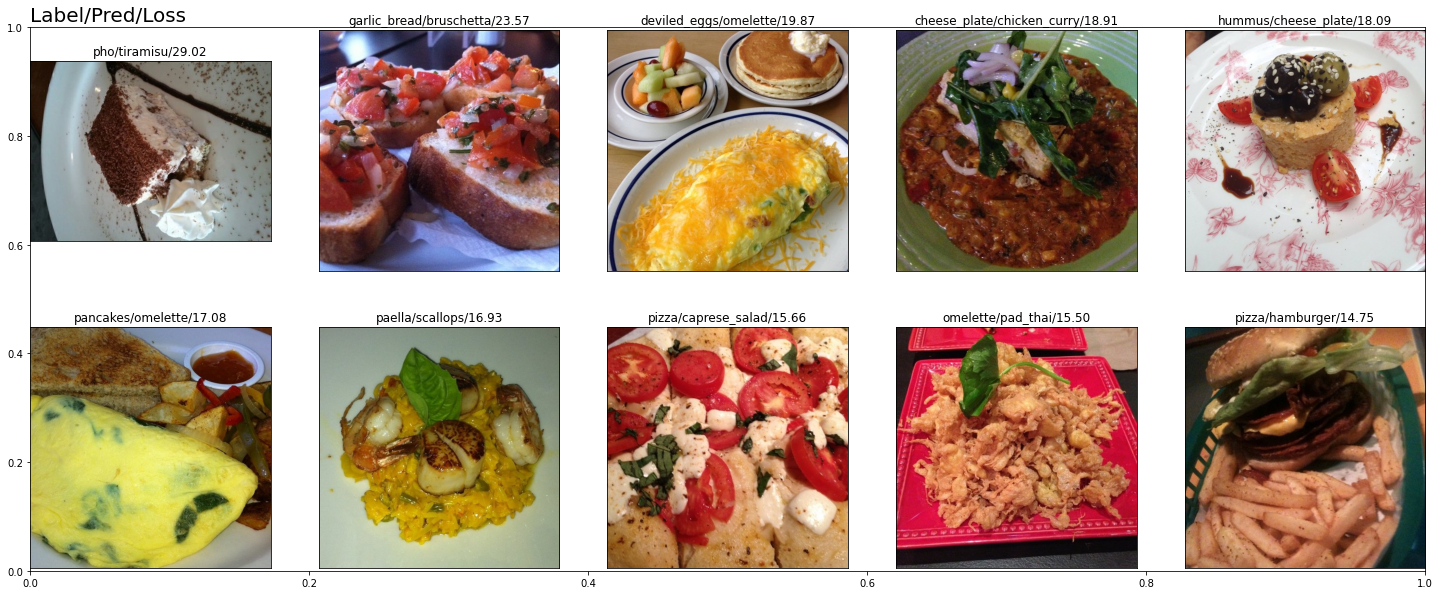

In [115]:
# show tests images with highest loss (top 10) and show their true label, predicition, and loss value
fig = plt.figure(figsize=(25, 10))
plt.title("Label/Pred/Loss", fontsize=20, loc='left')

for i in np.arange(10):
    ax = fig.add_subplot(2, 10/2, i+1, xticks=[], yticks=[])
    img = mpimg.imread(images_path[i])
    plt.imshow(img)
    ax.set_title(images_name[i])

After checking these wrong predicted images, the problems we mentioned in the beginning appears here.

    1. There are some noise images where the obvious images are wrongly labeled: Tiramisu labeled as Pho and Hamburger labeled as Pizza. Fortunately, the model itself predict the wrong labeled images corectly.
    2. There are confusions where more than one food categories appear: Paella and Scallops. Paella is a spanish rice dish with seafood as topping.
    3. High similarity: Omelette and Pad Thai. Pad Thai is a noodle dish. Since the omelette is cooked fried and scrambled, then it looks like noodle.

To investigate the prediction results further, we visualize the test set images using t-SNE based on its the embedding features (the output of 4th layer, 2048 feature vector) of trained Resnet-50 model. The feature vector itself is the average of TTA predicition.

We will analyze the 10 classes with lowest and highest accuracy to see the relationship between classes.

In [187]:
# crate Label name column
evalution_results_df["Label name"] = [name_class[label] for label in evalution_results_df["Labels"]]
# crate Prediction name column
evalution_results_df["Prediction name"] = [name_class[pred] for pred in evalution_results_df["Prediction"]]
# crete a column to store an information whether the predicition is correct
evalution_results_df["Results"] = evalution_results_df['Labels'] == evalution_results_df['Prediction']

In [224]:
# crate Class Accuracy column
evalution_results_df["Class Accuracy"] = ""
# calculate accuracy per class
for i in range(len(name_class)) :
    evalution_results_df.loc[evalution_results_df[evalution_results_df["Labels"] == i].index, 
                             "Class Accuracy"] = evalution_results_df[evalution_results_df["Labels"] == i]["Results"].mean()*100

In [229]:
# sort the Dataframe in ascending manner based on accuracy
evalution_results_df = evalution_results_df.sort_values(by ='Class Accuracy', ascending=True).reset_index(drop=True)

In [362]:
# choose 10 colors for 10 classes and 1 color for the rest
color_list = ["royalblue", "olive", "m", "dodgerblue", "seagreen",
              "gold", "orange", "saddlebrown", "red", "lime", "navy",
              "lightgrey"]

In [363]:
# first set all color to common one
evalution_results_df["Color"] = color_list[-1]

In [364]:
# set 10 class's color
for i in range(10) : 
    evalution_results_df.loc[i*250:i*250+250, "Color"] = color_list[i]

In [243]:
# create a list of feature vectors where the order is based on accuracy
new_feature_vec_list = np.array([feature_vec_list[idx] for idx in evalution_results_df["Feature"]])

In [245]:
# create t-SNE embedding for visualization
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time.time()
X_tsne = tsne.fit_transform(new_feature_vec_list)
calculate_tsne_time = (time.time() - t0)
print("t-SNE training time ", datetime.timedelta(seconds=int(calculate_tsne_time)))

Computing t-SNE embedding
t-SNE training time  0:59:43


In [378]:
# crate a list of label name and accuracy for plot's legend
class_top_acc_legend = []
for i in range(10) : 
    class_top_acc_legend.append(evalution_results_df.loc[i*250, "Label name"] + " " + 
                         '%.2f' % evalution_results_df.loc[i*250, "Class Accuracy"] + "%")

In [379]:
# set custom legeds for 10 classes with lowest accuracy
legend_elements = [Line2D([0], [0], marker='o', color='w', label=class_lgd,
                          markerfacecolor=color, markersize=10) for (color,class_lgd) in zip(color_list[:-1], class_top_acc_legend)]

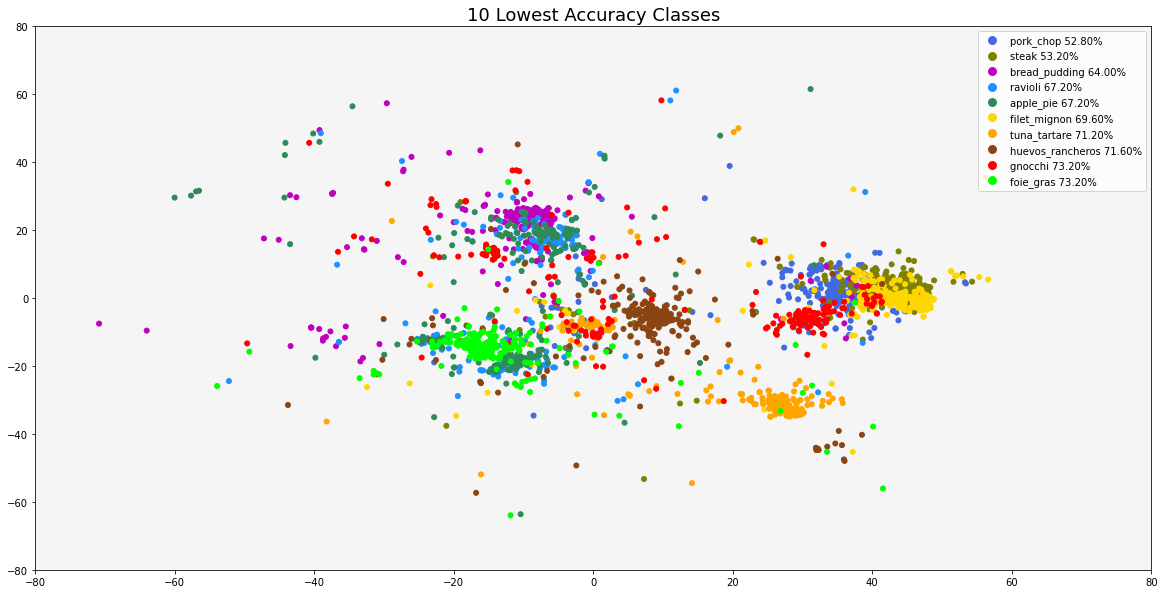

In [380]:
# set figure size
fig, ax = plt.subplots(figsize=(20, 10))

# set show_all to True if you want to see other classes, but their color are all grey 
show_all = False
if show_all :
    # show all
    X_tsne_lowest = X_tsne
    color_dots = evalution_results_df["Color"]
else:
    # show only 10 classes
    X_tsne_lowest = X_tsne[:10*250,:]
    color_dots = evalution_results_df["Color"][:10*250]

# set scatter plot based on first component as x-axis and second component as y-axis
# use the same color as previous
scatter = ax.scatter(X_tsne_lowest[:,0], 
                     X_tsne_lowest[:,1], 
                     s=25, c=color_dots)
# set background color
ax.set_facecolor('whitesmoke')
# set legend
ax.legend(handles=legend_elements, loc='upper right')
# set title
plt.title("10 Lowest Accuracy Classes", fontsize=18)
# set axis range
plt.xlim(-80, 80)
plt.ylim(-80, 80)
# show the plot
plt.show()

In this plot, we only show 10 classes, but if we want to see other classes, we can set show_all = True.

The plot above shows that low accuracy classes have tendency to overlap with other classes. One reason is that they could have a high similarity. The examples are bread pudding and apple pie, then pork chop and fillet mignon. The picture below shows that. 

In [390]:
# set path and name of similar images
images_path = ["dataset/test/bread_pudding/3457739.jpg", 
               "dataset/test/apple_pie/3242509.jpg", 
               "dataset/test/pork_chop/376153.jpg", 
               "dataset/test/filet_mignon/368040.jpg"]
images_name = ["Bread Pudding", "Apple Pie", "Pork Chop", "Filet Mignon"]

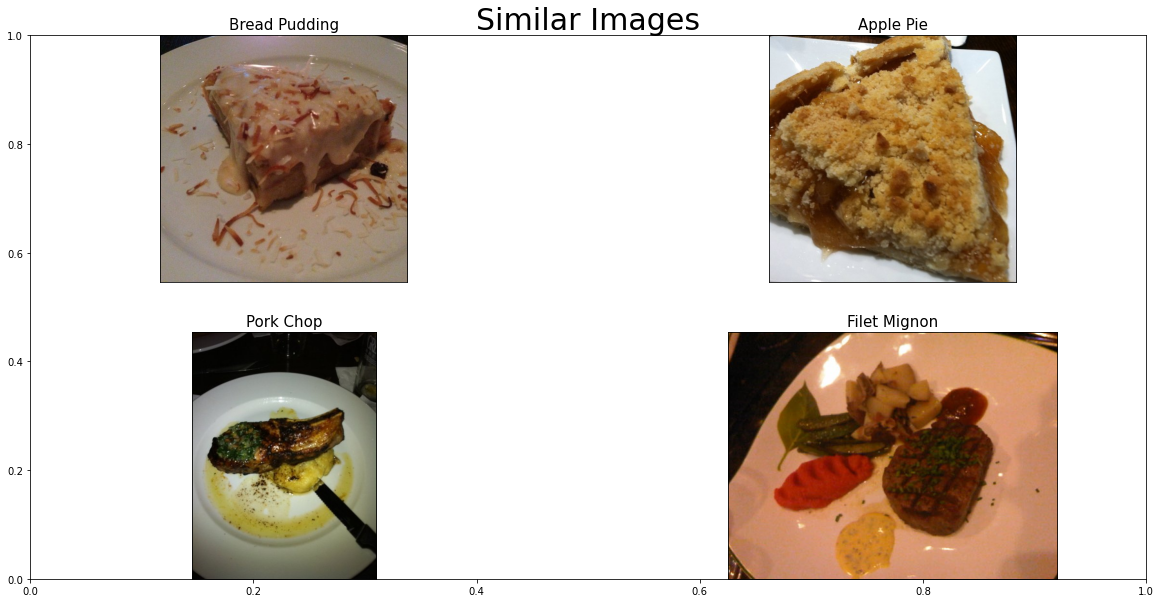

In [397]:
# show similar images
fig = plt.figure(figsize=(20, 10))
plt.title("Similar Images", fontsize=30, loc='center')

for i in np.arange(4):
    ax = fig.add_subplot(2, 4/2, i+1, xticks=[], yticks=[])
    img = mpimg.imread(images_path[i])
    plt.imshow(img)
    ax.set_title(images_name[i], fontsize=15)

Now we will analyze the 10 classes with highest accuracy

In [375]:
# crate a list of label name and accuracy for plot's legend
class_top_acc_legend = []
for i in reversed(range(1,11)) : 
    class_top_acc_legend.append(evalution_results_df.loc[25250-i*250+1, "Label name"] + " " + 
                         '%.2f' % evalution_results_df.loc[25250-i*250+1, "Class Accuracy"] + "%")

In [376]:
# set custom legeds for 10 classes with highest accuracy
legend_elements = [Line2D([0], [0], marker='o', color='w', label=class_lgd,
                          markerfacecolor=color, markersize=10) for (color,class_lgd) in zip(color_list[:-1], class_top_acc_legend)]

In [377]:
# set figure size
fig, ax = plt.subplots(figsize=(20, 10))

# set show_all to True if you want to see other classes, but their color are all grey 
show_all = False
if show_all :
    # show all
    X_tsne_highest = np.vstack((X_tsne[-10*250:,:], X_tsne[:-10*250,:]))
    color_dots = evalution_results_df["Color"]
else:
    # show only 10 classes
    X_tsne_highest = X_tsne[-10*250:,:]
    color_dots = evalution_results_df["Color"][:10*250]

# set scatter plot based on first component as x-axis and second component as y-axis
# use the same color as previous
scatter = ax.scatter(X_tsne_highest[:,0], 
                     X_tsne_highest[:,1], 
                     s=25, c=color_dots)
# set background color
ax.set_facecolor('whitesmoke')
# set legend
ax.legend(handles=legend_elements, loc='upper right')
# set title
plt.title("10 Highest Accuracy Classes", fontsize=18)
# set axis range
plt.xlim(-80, 80)
plt.ylim(-80, 80)
# show the plot
plt.show()

In this plot, we only show 10 classes, but if we want to see other classes, we can set show_all = True.

Meanwhile, high accuracy classes are separated relatively well to other classes. It might be that they are quite unique food and quite distinguishable with other food. We will shows edamame and takoyaki.

In [401]:
# set path and name of distinguishable images
images_path = ["dataset/test/edamame/334938.jpg", 
               "dataset/test/takoyaki/1570074.jpg"]
images_name = ["Edamame", "Takoyaki"]

In [406]:
# show distinguishable images
fig = plt.figure(figsize=(10, 5))
plt.title("Distinguishable Images", fontsize=15, loc='center')

for i in np.arange(2):
    ax = fig.add_subplot(1, 4/2, i+1, xticks=[], yticks=[])
    img = mpimg.imread(images_path[i])
    plt.imshow(img)
    ax.set_title(images_name[i], fontsize=10)

### Future Work
As the last few epochs shows, the performance start saturating. Merely adding more epoch won't do any good. Thus another strategy must be employed if we want to increase the accuracy.

Our suggestions to improve the performance of the model are :



1.   **Anti Aliasing** <br/>
Convolutional networks are not shift-invariant. The outputs of network is prone to small shifts or translation. This happens because the striding operation ignores the the Nyquist sampling theorem and aliases, which breaks shift equivariance. <br/>
This [paper](https://arxiv.org/abs/1904.11486) proposed a method by adding "Blurpool" layer maxpool layer and strided convolution layer. The method was shown to increase both classification consistency between different shift of images and classification accuracy due to effective regularization.<br/>

<!---  
<img src="https://miro.medium.com/max/2506/1*1asLyTb5ALjf3vuNTSWMiw.png" width=300 align=right>--->



2.   **Snapshot Ensembling** <br/>
This [method](https://arxiv.org/abs/1704.00109) saves the model’s parameters periodically during training. The idea is that using cycling LR scheduling, the model is expected to reach different local minima. Thus, we obtain a set of models with different insights for our prediction in a single training cycle. <br/>
Afterwards, the probability predictions of each models are concatenated to form a new data. Thens we use XGBoost model to give a prediction based on the new data.

<!--- 
![alt text](https://cdn-images-1.medium.com/max/2000/1*T5WWecP_EaQWk1yDX15h_w.png)
--->